In [10]:
!git clone https://github.com/dmc27/importance.git

fatal: destination path 'importance' already exists and is not an empty directory.


In [88]:
import numpy as np
import pandas as pd
import cv2 as cv
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.dpi'] = 125
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import signal

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [70]:
data = pd.read_excel('database\img_importance.xlsx', usecols="B:H")
PATCH_SIZE = 16
POSITION_LAMBDA = 1
TARING_SIZE = 0.2
IMAGE_AUG_NUM = 75

In [71]:
# divide one image into many patches(patch size:8*8 or 16*16 or 32*32), each patch coresponds to imporance of class(0,1,2)
# img: a original image
# patches: a list of patches
# imp_img_matrics: a matrix of importance of image(width,height,class)
# patch_imp: a list of matrix of importance of patches
def parse_img(img, patches, imp_img_matrics, patches_imp):
  num_rows = img.shape[0]
  num_cols = img.shape[1]
  
  #initial patch size
  patch = np.zeros((PATCH_SIZE, PATCH_SIZE, 3))
  # add imporance of class to each patch
  patch_imp = np.zeros((PATCH_SIZE, PATCH_SIZE))
  # add position information to the patch
  position_row = np.zeros((PATCH_SIZE, PATCH_SIZE, 1))
  position_col = np.zeros((PATCH_SIZE, PATCH_SIZE, 1))
  
  for r0 in range(0, num_rows-1, PATCH_SIZE):
    for c0 in range(0, num_cols-1, PATCH_SIZE):
  
      for r in range(PATCH_SIZE):
        for c in range(PATCH_SIZE):
          assert(r0 + r < num_rows)
          assert(c0 + c < num_cols)
          
          patch[r, c] =img[r0+r, c0+c]
          patch_imp[r, c] = imp_img_matrics[r0+r, c0+c]
          position_row[r, c] = r0 / (num_rows-1)
          position_col[r, c] = c0 / (num_cols-1)
        
      ## Calculate the maximum number of classes corresponding to each pixel in patch, representing the important class of this patch
      patches_imp.append(np.argmax(np.bincount(patch_imp.flatten().astype(int))))
      
      norm_patch = patch.copy()/255.0
      # each patch has five channels(R,G,B,position_row,position_col)
      five_d_patch = np.concatenate((norm_patch, position_row), axis=2)
      five_d_patch = np.concatenate((five_d_patch, position_col), axis=2)
      #add each patch to the list of patches
      patches.append(five_d_patch)

In [72]:
idx = 0
patches = []
patches_imp = []

tot_num_objs = 581
obj_sizes = np.zeros(tot_num_objs)
obj_locs = np.zeros(tot_num_objs)

for img_idx in tqdm(range(1, 151)):
  img_name = "img" + str(img_idx)
  img_data = data.loc[data["img_name"]==img_name]

  msk_name = img_name + "_msk"
  src_img = cv.imread("database/imgs/" + img_name + ".bmp")
  src_img = cv.cvtColor(src_img, cv.COLOR_BGR2RGB)
  msk_img = cv.imread("database/imgs/msk/" + msk_name + ".bmp")
  msk_img = cv.cvtColor(msk_img, cv.COLOR_BGR2RGB)

  num_rows = src_img.shape[0]
  num_cols = src_img.shape[1]

  imp_img_matrics = np.zeros((num_rows, num_cols))

  for obj_idx, obj_data in img_data.iterrows():
    obj_name = obj_data["obj_name"]
    obj_imp = obj_data["class"]
    msk_r = obj_data["R"]
    msk_g = obj_data["G"]
    msk_b = obj_data["B"]
    

    avg_r = 0
    avg_c = 0
    obj_size = 0
    for r in range(num_rows):
      for c in range(num_cols):
        if msk_img[r, c, 0] == msk_r and \
          msk_img[r, c, 1] == msk_g and \
          msk_img[r, c, 2] == msk_b:
          avg_r += r
          avg_c += c
          obj_size += 1 
          imp_img_matrics[r, c] = obj_imp

    avg_r /= obj_size
    avg_c /= obj_size
  
    obj_loc = \
      np.sqrt((avg_r-num_rows/2)**2 + (avg_c-num_cols/2)**2)
    obj_loc = 100*obj_loc/289.13175
    
    obj_sizes[idx] = obj_size
    obj_locs[idx] = obj_loc
    idx += 1

  if (img_idx<=IMAGE_AUG_NUM):
    parse_img(np.fliplr(src_img), patches, np.fliplr(imp_img_matrics), patches_imp)
  
  parse_img(src_img, patches, imp_img_matrics, patches_imp)


100%|██████████| 150/150 [04:14<00:00,  1.69s/it]


In [73]:
# Half of the patches are used for training, the other half for testing

X_trn = np.zeros((int(len(patches)/3*2), PATCH_SIZE, PATCH_SIZE, 5))
y_trn = np.zeros((int(len(patches_imp)/3*2), 1))

for i in range(int((len(patches)/3*2))):
  X_trn[i,:] = patches[i]
  y_trn[i] = patches_imp[i]
print("X_trn shape:", X_trn.shape)


X_trn shape: (90000, 16, 16, 5)


In [76]:
reuse_pre_model = False

# model_fname = "saved_models/important_CNN.0.h5"

if reuse_pre_model and os.path.exists(model_fname):
    print("Reloading previous model: ", model_fname)
    model = load_model(model_fname)
else:
    print("Creating new model")
    model_fname = "saved_models/important_CNN.0.h5"

    model = Sequential()
    model.add(Conv2D(2, kernel_size = 3, input_shape=(PATCH_SIZE, PATCH_SIZE, 5), activation = "relu", padding = "same"))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())

    model.add(Conv2D(4, kernel_size = 3, activation = "relu", padding = "same"))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())

    model.add(Conv2D(8, kernel_size = 3, activation = "relu", padding = "same"))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(20, activation="relu"))
    model.add(Dense(3, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", 
        optimizer="adam", metrics=["accuracy"])

model.summary()

Creating new model
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 16, 16, 2)         92        
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 8, 8, 2)          0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 8, 8, 2)          8         
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 8, 8, 4)           76        
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 4, 4, 4)          0         
 g2D)                                                            
                                   

In [79]:
checkpoint = ModelCheckpoint(model_fname, monitor='loss', verbose=1, 
  save_best_only=True)
callbacks_list = [checkpoint]

# fit the model
history = model.fit(X_trn, y_trn, epochs=100, batch_size=20,
  validation_split=0.15, callbacks=callbacks_list)

Epoch 1/100
3811/3825 [============================>.] - ETA: 0s - loss: 0.9045 - accuracy: 0.5786
Epoch 1: loss improved from inf to 0.90447, saving model to saved_models\important_CNN.0.h5
3825/3825 [==============================] - 13s 4ms/step - loss: 0.9045 - accuracy: 0.5786 - val_loss: 0.8005 - val_accuracy: 0.6504
Epoch 2/100
3819/3825 [============================>.] - ETA: 0s - loss: 0.8891 - accuracy: 0.5861
Epoch 2: loss improved from 0.90447 to 0.88899, saving model to saved_models\important_CNN.0.h5
3825/3825 [==============================] - 13s 3ms/step - loss: 0.8890 - accuracy: 0.5862 - val_loss: 0.8666 - val_accuracy: 0.6002
Epoch 3/100
3814/3825 [============================>.] - ETA: 0s - loss: 0.8763 - accuracy: 0.5950
Epoch 3: loss improved from 0.88899 to 0.87638, saving model to saved_models\important_CNN.0.h5
3825/3825 [==============================] - 13s 3ms/step - loss: 0.8764 - accuracy: 0.5949 - val_loss: 0.8496 - val_accuracy: 0.6113
Epoch 4/100
3823/

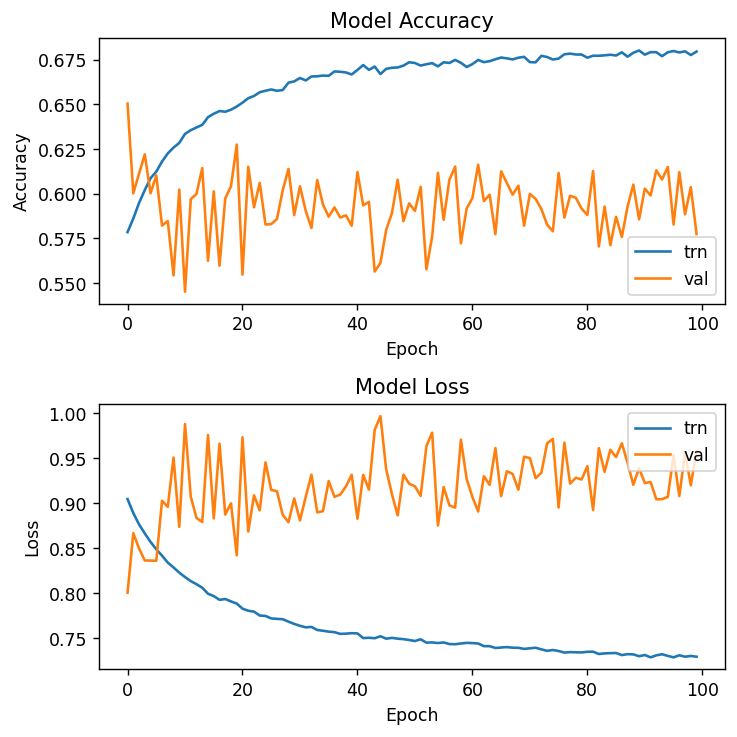

In [80]:
fig = plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['trn', 'val'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['trn', 'val'], loc='upper right')
plt.tight_layout()


In [81]:
def test_img_parse(img, patches):
    num_rows = img.shape[0]
    num_cols = img.shape[1]
    
    patch = np.zeros((PATCH_SIZE, PATCH_SIZE, 3))
    position_row = np.zeros((PATCH_SIZE, PATCH_SIZE, 1))
    position_col = np.zeros((PATCH_SIZE, PATCH_SIZE, 1))
    
    for r0 in range(0, num_rows-1, PATCH_SIZE):
        for c0 in range(0, num_cols-1, PATCH_SIZE):
        
           
            for r in range(PATCH_SIZE):
                for c in range(PATCH_SIZE):
                    assert(r0 + r < num_rows)
                    assert(c0 + c < num_cols)

                    patch[r, c] =img[r0+r, c0+c]
                    position_row[r, c] = r0 / (num_rows-1)
                    position_col[r, c] = c0 / (num_cols-1)
            
            
            norm_patch = patch.copy()/255.0
      
            five_d_patch = np.concatenate((norm_patch, position_row), axis=2)
            five_d_patch = np.concatenate((five_d_patch, position_col), axis=2)
            patches.append(five_d_patch)
    


In [82]:

def recover_imp (test_imp_matrics, imp_pred_matrics):
    row = imp_pred_matrics.shape[0]
    col = imp_pred_matrics.shape[1]
    for r0 in range(0, row-1, PATCH_SIZE):
        for c0 in range(0, col-1, PATCH_SIZE):
      
            for r in range(PATCH_SIZE):
                for c in range(PATCH_SIZE):
                    imp_pred_matrics[r+r0,c+c0] = test_imp_matrics[int(r0/PATCH_SIZE),int(c0/PATCH_SIZE)]

In [83]:
object_imp = np.zeros(581)
idx = 0
for img_idx in tqdm(range(1, 151)):
  img_name = "img" + str(img_idx)
  img_data = data.loc[data["img_name"]==img_name]

  src_img = cv.imread("database/imgs/" + img_name + ".bmp")
  src_img = cv.cvtColor(src_img, cv.COLOR_BGR2RGB)
  msk_img = cv.imread(
  "database/imgs/msk/" + img_name + "_msk.bmp")
  msk_img = cv.cvtColor(msk_img, cv.COLOR_BGR2RGB)

  num_rows = src_img.shape[0]
  num_cols = src_img.shape[1]
  
  test_patches = []
  imp_pred_matrics = np.zeros((num_rows, num_cols))
  test_img_parse(src_img, test_patches)
  
  X_tst = np.zeros((len(test_patches), PATCH_SIZE, PATCH_SIZE, 5))

  for i in range(len(test_patches)):
   X_tst[i,:] = test_patches[i]

  y_tst_prd = model.predict(X_tst)
  test_imp_matrics = np.argmax(y_tst_prd, axis=1).reshape(int((num_rows-1)/PATCH_SIZE), int((num_cols-1)/PATCH_SIZE))
  recover_imp(test_imp_matrics, imp_pred_matrics)
  
  for obj_idx, obj_data in img_data.iterrows():
    obj_name = obj_data["obj_name"]
    obj_imp = obj_data["class"]
    msk_r = obj_data["R"]
    msk_g = obj_data["G"]
    msk_b = obj_data["B"]
    
    importance = []
    for r in range(num_rows):
      for c in range(num_cols):
        if msk_img[r, c, 0] == msk_r and \
          msk_img[r, c, 1] == msk_g and \
          msk_img[r, c, 2] == msk_b:
          
          importance.append(imp_pred_matrics[r, c])
          
    #Calculate the maximum number of important classes corresponding to each pixel in object
    object_imp[idx] = np.argmax(np.bincount(importance))
    idx += 1
print(object_imp)

  0%|          | 0/150 [00:00<?, ?it/s]

19/19 [==============================] - 0s 3ms/step


  1%|          | 1/150 [00:01<04:39,  1.87s/it]

19/19 [==============================] - 0s 1ms/step


  1%|▏         | 2/150 [00:03<04:20,  1.76s/it]

19/19 [==============================] - 0s 1ms/step


  2%|▏         | 3/150 [00:06<05:18,  2.16s/it]

19/19 [==============================] - 0s 1ms/step


  3%|▎         | 4/150 [00:08<05:16,  2.17s/it]

19/19 [==============================] - 0s 1ms/step


  3%|▎         | 5/150 [00:10<05:05,  2.11s/it]

19/19 [==============================] - 0s 1ms/step


  4%|▍         | 6/150 [00:12<04:42,  1.96s/it]

19/19 [==============================] - 0s 1ms/step


  5%|▍         | 7/150 [00:13<04:04,  1.71s/it]

19/19 [==============================] - 0s 1ms/step


  5%|▌         | 8/150 [00:14<03:48,  1.61s/it]

19/19 [==============================] - 0s 1ms/step


  6%|▌         | 9/150 [00:17<04:38,  1.98s/it]

19/19 [==============================] - 0s 1ms/step


  7%|▋         | 10/150 [00:18<04:11,  1.79s/it]

19/19 [==============================] - 0s 1ms/step


  7%|▋         | 11/150 [00:20<04:08,  1.79s/it]

19/19 [==============================] - 0s 1ms/step


  8%|▊         | 12/150 [00:22<03:58,  1.73s/it]

19/19 [==============================] - 0s 1ms/step


  9%|▊         | 13/150 [00:23<03:43,  1.63s/it]

19/19 [==============================] - 0s 1ms/step


  9%|▉         | 14/150 [00:25<03:37,  1.60s/it]

19/19 [==============================] - 0s 1ms/step


 10%|█         | 15/150 [00:26<03:19,  1.48s/it]

19/19 [==============================] - 0s 1ms/step


 11%|█         | 16/150 [00:27<03:13,  1.45s/it]

19/19 [==============================] - 0s 1ms/step


 11%|█▏        | 17/150 [00:29<03:25,  1.55s/it]

19/19 [==============================] - 0s 1ms/step


 12%|█▏        | 18/150 [00:30<03:17,  1.50s/it]

19/19 [==============================] - 0s 1ms/step


 13%|█▎        | 19/150 [00:32<03:12,  1.47s/it]

19/19 [==============================] - 0s 1ms/step


 13%|█▎        | 20/150 [00:33<03:07,  1.44s/it]

19/19 [==============================] - 0s 1ms/step


 14%|█▍        | 21/150 [00:34<03:03,  1.42s/it]

19/19 [==============================] - 0s 1ms/step


 15%|█▍        | 22/150 [00:36<03:06,  1.46s/it]

19/19 [==============================] - 0s 1ms/step


 15%|█▌        | 23/150 [00:37<03:02,  1.44s/it]

19/19 [==============================] - 0s 1ms/step


 16%|█▌        | 24/150 [00:40<03:45,  1.79s/it]

19/19 [==============================] - 0s 1ms/step


 17%|█▋        | 25/150 [00:41<03:28,  1.67s/it]

19/19 [==============================] - 0s 1ms/step


 17%|█▋        | 26/150 [00:43<03:08,  1.52s/it]

19/19 [==============================] - 0s 1ms/step


 18%|█▊        | 27/150 [00:45<03:27,  1.69s/it]

19/19 [==============================] - 0s 1ms/step


 19%|█▊        | 28/150 [00:46<03:07,  1.54s/it]

19/19 [==============================] - 0s 1ms/step


 19%|█▉        | 29/150 [00:48<03:14,  1.60s/it]

19/19 [==============================] - 0s 1ms/step


 20%|██        | 30/150 [00:50<03:37,  1.81s/it]

19/19 [==============================] - 0s 1ms/step


 21%|██        | 31/150 [00:51<03:20,  1.68s/it]

19/19 [==============================] - 0s 1ms/step


 21%|██▏       | 32/150 [00:53<03:24,  1.73s/it]

19/19 [==============================] - 0s 1ms/step


 22%|██▏       | 33/150 [00:55<03:29,  1.79s/it]

19/19 [==============================] - 0s 1ms/step


 23%|██▎       | 34/150 [00:57<03:32,  1.83s/it]

19/19 [==============================] - 0s 1ms/step


 23%|██▎       | 35/150 [00:59<03:26,  1.79s/it]

19/19 [==============================] - 0s 1ms/step


 24%|██▍       | 36/150 [01:00<03:11,  1.68s/it]

19/19 [==============================] - 0s 1ms/step


 25%|██▍       | 37/150 [01:02<03:00,  1.59s/it]

19/19 [==============================] - 0s 1ms/step


 25%|██▌       | 38/150 [01:03<02:57,  1.59s/it]

19/19 [==============================] - 0s 1ms/step


 26%|██▌       | 39/150 [01:05<02:56,  1.59s/it]

19/19 [==============================] - 0s 1ms/step


 27%|██▋       | 40/150 [01:06<02:48,  1.53s/it]

19/19 [==============================] - 0s 1ms/step


 27%|██▋       | 41/150 [01:09<03:21,  1.85s/it]

19/19 [==============================] - 0s 1ms/step


 28%|██▊       | 42/150 [01:10<03:04,  1.70s/it]

19/19 [==============================] - 0s 1ms/step


 29%|██▊       | 43/150 [01:11<02:52,  1.61s/it]

19/19 [==============================] - 0s 1ms/step


 29%|██▉       | 44/150 [01:13<02:38,  1.50s/it]

19/19 [==============================] - 0s 1ms/step


 30%|███       | 45/150 [01:14<02:43,  1.55s/it]

19/19 [==============================] - 0s 1ms/step


 31%|███       | 46/150 [01:16<02:30,  1.45s/it]

19/19 [==============================] - 0s 1ms/step


 31%|███▏      | 47/150 [01:17<02:43,  1.59s/it]

19/19 [==============================] - 0s 1ms/step


 32%|███▏      | 48/150 [01:19<02:41,  1.58s/it]

19/19 [==============================] - 0s 1ms/step


 33%|███▎      | 49/150 [01:21<02:44,  1.63s/it]

19/19 [==============================] - 0s 1ms/step


 33%|███▎      | 50/150 [01:23<02:46,  1.67s/it]

19/19 [==============================] - 0s 1ms/step


 34%|███▍      | 51/150 [01:24<02:42,  1.64s/it]

19/19 [==============================] - 0s 1ms/step


 35%|███▍      | 52/150 [01:26<02:38,  1.61s/it]

19/19 [==============================] - 0s 1ms/step


 35%|███▌      | 53/150 [01:27<02:35,  1.60s/it]

19/19 [==============================] - 0s 1ms/step


 36%|███▌      | 54/150 [01:28<02:21,  1.47s/it]

19/19 [==============================] - 0s 1ms/step


 37%|███▋      | 55/150 [01:30<02:12,  1.39s/it]

19/19 [==============================] - 0s 1ms/step


 37%|███▋      | 56/150 [01:31<02:15,  1.44s/it]

19/19 [==============================] - 0s 1ms/step


 38%|███▊      | 57/150 [01:33<02:12,  1.42s/it]

19/19 [==============================] - 0s 1ms/step


 39%|███▊      | 58/150 [01:35<02:30,  1.63s/it]

19/19 [==============================] - 0s 1ms/step


 39%|███▉      | 59/150 [01:36<02:22,  1.56s/it]

19/19 [==============================] - 0s 1ms/step


 40%|████      | 60/150 [01:38<02:31,  1.68s/it]

19/19 [==============================] - 0s 1ms/step


 41%|████      | 61/150 [01:40<02:37,  1.77s/it]

19/19 [==============================] - 0s 1ms/step


 41%|████▏     | 62/150 [01:42<02:41,  1.84s/it]

19/19 [==============================] - 0s 1ms/step


 42%|████▏     | 63/150 [01:44<02:49,  1.95s/it]

19/19 [==============================] - 0s 1ms/step


 43%|████▎     | 64/150 [01:46<02:48,  1.95s/it]

19/19 [==============================] - 0s 1ms/step


 43%|████▎     | 65/150 [01:48<02:50,  2.01s/it]

19/19 [==============================] - 0s 1ms/step


 44%|████▍     | 66/150 [01:50<02:38,  1.88s/it]

19/19 [==============================] - 0s 1ms/step


 45%|████▍     | 67/150 [01:52<02:36,  1.88s/it]

19/19 [==============================] - 0s 1ms/step


 45%|████▌     | 68/150 [01:54<02:38,  1.93s/it]

19/19 [==============================] - 0s 1ms/step


 46%|████▌     | 69/150 [01:55<02:27,  1.82s/it]

19/19 [==============================] - 0s 1ms/step


 47%|████▋     | 70/150 [01:57<02:19,  1.75s/it]

19/19 [==============================] - 0s 1ms/step


 47%|████▋     | 71/150 [01:59<02:13,  1.69s/it]

19/19 [==============================] - 0s 1ms/step


 48%|████▊     | 72/150 [02:00<02:08,  1.65s/it]

19/19 [==============================] - 0s 1ms/step


 49%|████▊     | 73/150 [02:01<01:56,  1.51s/it]

19/19 [==============================] - 0s 1ms/step


 49%|████▉     | 74/150 [02:03<01:56,  1.53s/it]

19/19 [==============================] - 0s 1ms/step


 50%|█████     | 75/150 [02:04<01:55,  1.55s/it]

19/19 [==============================] - 0s 1ms/step


 51%|█████     | 76/150 [02:07<02:12,  1.79s/it]

19/19 [==============================] - 0s 1ms/step


 51%|█████▏    | 77/150 [02:09<02:13,  1.83s/it]

19/19 [==============================] - 0s 1ms/step


 52%|█████▏    | 78/150 [02:10<02:02,  1.70s/it]

19/19 [==============================] - 0s 1ms/step


 53%|█████▎    | 79/150 [02:11<01:53,  1.60s/it]

19/19 [==============================] - 0s 1ms/step


 53%|█████▎    | 80/150 [02:13<01:43,  1.48s/it]

19/19 [==============================] - 0s 1ms/step


 54%|█████▍    | 81/150 [02:15<01:51,  1.62s/it]

19/19 [==============================] - 0s 1ms/step


 55%|█████▍    | 82/150 [02:16<01:55,  1.69s/it]

19/19 [==============================] - 0s 1ms/step


 55%|█████▌    | 83/150 [02:18<01:47,  1.60s/it]

19/19 [==============================] - 0s 1ms/step


 56%|█████▌    | 84/150 [02:20<01:47,  1.63s/it]

19/19 [==============================] - 0s 1ms/step


 57%|█████▋    | 85/150 [02:21<01:52,  1.73s/it]

19/19 [==============================] - 0s 1ms/step


 57%|█████▋    | 86/150 [02:23<01:51,  1.74s/it]

19/19 [==============================] - 0s 1ms/step


 58%|█████▊    | 87/150 [02:25<01:42,  1.63s/it]

19/19 [==============================] - 0s 1ms/step


 59%|█████▊    | 88/150 [02:26<01:36,  1.55s/it]

19/19 [==============================] - 0s 1ms/step


 59%|█████▉    | 89/150 [02:27<01:32,  1.51s/it]

19/19 [==============================] - 0s 1ms/step


 60%|██████    | 90/150 [02:29<01:35,  1.59s/it]

19/19 [==============================] - 0s 1ms/step


 61%|██████    | 91/150 [02:31<01:33,  1.59s/it]

19/19 [==============================] - 0s 1ms/step


 61%|██████▏   | 92/150 [02:32<01:28,  1.53s/it]

19/19 [==============================] - 0s 1ms/step


 62%|██████▏   | 93/150 [02:34<01:25,  1.49s/it]

19/19 [==============================] - 0s 1ms/step


 63%|██████▎   | 94/150 [02:35<01:18,  1.41s/it]

19/19 [==============================] - 0s 1ms/step


 63%|██████▎   | 95/150 [02:36<01:19,  1.45s/it]

19/19 [==============================] - 0s 1ms/step


 64%|██████▍   | 96/150 [02:38<01:17,  1.43s/it]

19/19 [==============================] - 0s 1ms/step


 65%|██████▍   | 97/150 [02:39<01:15,  1.42s/it]

19/19 [==============================] - 0s 1ms/step


 65%|██████▌   | 98/150 [02:41<01:24,  1.63s/it]

19/19 [==============================] - 0s 1ms/step


 66%|██████▌   | 99/150 [02:42<01:16,  1.50s/it]

19/19 [==============================] - 0s 1ms/step


 67%|██████▋   | 100/150 [02:44<01:16,  1.53s/it]

19/19 [==============================] - 0s 1ms/step


 67%|██████▋   | 101/150 [02:45<01:12,  1.48s/it]

19/19 [==============================] - 0s 1ms/step


 68%|██████▊   | 102/150 [02:47<01:12,  1.51s/it]

19/19 [==============================] - 0s 1ms/step


 69%|██████▊   | 103/150 [02:49<01:20,  1.72s/it]

19/19 [==============================] - 0s 1ms/step


 69%|██████▉   | 104/150 [02:51<01:23,  1.82s/it]

19/19 [==============================] - 0s 1ms/step


 70%|███████   | 105/150 [02:53<01:18,  1.74s/it]

19/19 [==============================] - 0s 1ms/step


 71%|███████   | 106/150 [02:54<01:12,  1.64s/it]

19/19 [==============================] - 0s 1ms/step


 71%|███████▏  | 107/150 [02:56<01:11,  1.67s/it]

19/19 [==============================] - 0s 1ms/step


 72%|███████▏  | 108/150 [02:58<01:08,  1.64s/it]

19/19 [==============================] - 0s 1ms/step


 73%|███████▎  | 109/150 [02:59<01:01,  1.51s/it]

19/19 [==============================] - 0s 1ms/step


 73%|███████▎  | 110/150 [03:00<00:58,  1.46s/it]

19/19 [==============================] - 0s 1ms/step


 74%|███████▍  | 111/150 [03:02<01:00,  1.54s/it]

19/19 [==============================] - 0s 1ms/step


 75%|███████▍  | 112/150 [03:03<00:59,  1.57s/it]

19/19 [==============================] - 0s 1ms/step


 75%|███████▌  | 113/150 [03:05<00:56,  1.52s/it]

19/19 [==============================] - 0s 1ms/step


 76%|███████▌  | 114/150 [03:07<00:56,  1.57s/it]

19/19 [==============================] - 0s 1ms/step


 77%|███████▋  | 115/150 [03:08<00:51,  1.46s/it]

19/19 [==============================] - 0s 1ms/step


 77%|███████▋  | 116/150 [03:09<00:46,  1.38s/it]

19/19 [==============================] - 0s 1ms/step


 78%|███████▊  | 117/150 [03:11<00:49,  1.51s/it]

19/19 [==============================] - 0s 1ms/step


 79%|███████▊  | 118/150 [03:13<00:51,  1.60s/it]

19/19 [==============================] - 0s 1ms/step


 79%|███████▉  | 119/150 [03:14<00:49,  1.60s/it]

19/19 [==============================] - 0s 1ms/step


 80%|████████  | 120/150 [03:16<00:51,  1.70s/it]

19/19 [==============================] - 0s 1ms/step


 81%|████████  | 121/150 [03:17<00:44,  1.55s/it]

19/19 [==============================] - 0s 1ms/step


 81%|████████▏ | 122/150 [03:18<00:40,  1.44s/it]

19/19 [==============================] - 0s 1ms/step


 82%|████████▏ | 123/150 [03:20<00:38,  1.43s/it]

19/19 [==============================] - 0s 1ms/step


 83%|████████▎ | 124/150 [03:22<00:42,  1.63s/it]

19/19 [==============================] - 0s 1ms/step


 83%|████████▎ | 125/150 [03:24<00:41,  1.66s/it]

19/19 [==============================] - 0s 1ms/step


 84%|████████▍ | 126/150 [03:26<00:41,  1.74s/it]

19/19 [==============================] - 0s 1ms/step


 85%|████████▍ | 127/150 [03:27<00:40,  1.77s/it]

19/19 [==============================] - 0s 1ms/step


 85%|████████▌ | 128/150 [03:29<00:38,  1.76s/it]

19/19 [==============================] - 0s 1ms/step


 86%|████████▌ | 129/150 [03:31<00:34,  1.65s/it]

19/19 [==============================] - 0s 1ms/step


 87%|████████▋ | 130/150 [03:32<00:30,  1.51s/it]

19/19 [==============================] - 0s 1ms/step


 87%|████████▋ | 131/150 [03:33<00:26,  1.41s/it]

19/19 [==============================] - 0s 1ms/step


 88%|████████▊ | 132/150 [03:35<00:26,  1.45s/it]

19/19 [==============================] - 0s 1ms/step


 89%|████████▊ | 133/150 [03:36<00:23,  1.38s/it]

19/19 [==============================] - 0s 1ms/step


 89%|████████▉ | 134/150 [03:38<00:25,  1.56s/it]

19/19 [==============================] - 0s 1ms/step


 90%|█████████ | 135/150 [03:39<00:22,  1.50s/it]

19/19 [==============================] - 0s 1ms/step


 91%|█████████ | 136/150 [03:40<00:20,  1.46s/it]

19/19 [==============================] - 0s 1ms/step


 91%|█████████▏| 137/150 [03:42<00:19,  1.50s/it]

19/19 [==============================] - 0s 1ms/step


 92%|█████████▏| 138/150 [03:43<00:16,  1.41s/it]

19/19 [==============================] - 0s 1ms/step


 93%|█████████▎| 139/150 [03:45<00:15,  1.39s/it]

19/19 [==============================] - 0s 1ms/step


 93%|█████████▎| 140/150 [03:46<00:14,  1.47s/it]

19/19 [==============================] - 0s 1ms/step


 94%|█████████▍| 141/150 [03:48<00:14,  1.64s/it]

19/19 [==============================] - 0s 1ms/step


 95%|█████████▍| 142/150 [03:50<00:13,  1.73s/it]

19/19 [==============================] - 0s 1ms/step


 95%|█████████▌| 143/150 [03:52<00:12,  1.82s/it]

19/19 [==============================] - 0s 1ms/step


 96%|█████████▌| 144/150 [03:54<00:10,  1.76s/it]

19/19 [==============================] - 0s 1ms/step


 97%|█████████▋| 145/150 [03:56<00:08,  1.76s/it]

19/19 [==============================] - 0s 1ms/step


 97%|█████████▋| 146/150 [03:57<00:06,  1.64s/it]

19/19 [==============================] - 0s 1ms/step


 98%|█████████▊| 147/150 [03:59<00:05,  1.68s/it]

19/19 [==============================] - 0s 1ms/step


 99%|█████████▊| 148/150 [04:00<00:03,  1.59s/it]

19/19 [==============================] - 0s 1ms/step


 99%|█████████▉| 149/150 [04:02<00:01,  1.57s/it]

19/19 [==============================] - 0s 1ms/step


100%|██████████| 150/150 [04:04<00:00,  1.63s/it]

[2. 0. 1. 0. 2. 2. 2. 0. 2. 0. 2. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 2. 2. 0.
 0. 2. 2. 2. 0. 2. 0. 2. 2. 0. 2. 1. 2. 2. 0. 2. 2. 2. 0. 0. 2. 2. 0. 0.
 0. 2. 2. 0. 0. 2. 1. 2. 2. 2. 1. 0. 2. 2. 2. 0. 0. 2. 2. 0. 0. 0. 2. 2.
 0. 2. 0. 0. 2. 1. 2. 2. 2. 0. 2. 0. 0. 2. 2. 0. 2. 2. 1. 0. 2. 1. 1. 2.
 0. 0. 2. 0. 2. 1. 1. 0. 2. 0. 2. 0. 2. 2. 2. 2. 0. 0. 0. 0. 2. 2. 0. 0.
 2. 2. 0. 0. 2. 2. 2. 0. 2. 2. 0. 2. 0. 0. 0. 2. 2. 0. 1. 1. 0. 0. 2. 2.
 0. 2. 2. 2. 0. 2. 0. 1. 1. 2. 2. 0. 0. 2. 2. 2. 0. 0. 2. 2. 0. 1. 2. 2.
 0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 2. 0. 2. 2. 2. 2. 0. 0. 0. 2. 2. 0. 0. 0.
 2. 2. 0. 2. 0. 2. 2. 0. 0. 2. 0. 0. 0. 2. 0. 0. 0. 2. 0. 2. 0. 2. 0. 0.
 0. 2. 2. 0. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 2. 0. 2. 0. 2. 0. 2. 0. 2. 2.
 0. 2. 0. 2. 2. 2. 0. 0. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 1. 0. 2. 2. 2. 2.
 2. 2. 0. 2. 2. 0. 0. 2. 2. 0. 2. 0. 0. 2. 2. 0. 0. 2. 0. 2. 0. 2. 2. 0.
 2. 2. 2. 2. 2. 0. 0. 1. 0. 2. 0. 2. 0. 0. 2. 2. 2. 2. 0. 0. 2. 0. 0. 2.
 0. 2. 0. 0. 2. 0. 2. 0. 0. 2. 2. 2. 0. 0. 0. 2. 2.

In [84]:
data_tst = data.iloc[302:]
y_tst = np.array(data_tst["class"])
print(y_tst.shape)
print(object_imp.shape)
print('Testing accuracy: ', 
  accuracy_score(y_true=y_tst, y_pred=object_imp[302:]))

(279,)
(581,)
Testing accuracy:  0.6272401433691757


In [85]:
data.insert(data.shape[1]-1, "size", obj_sizes) 
data.insert(data.shape[1]-1, "loc", obj_locs)
data.insert(data.shape[1]-1, "cnn_imp", object_imp)
data.head(20)




,num_objs,img_name,obj_name,R,G,B,size,loc,cnn_imp,class
0,4,img1,bridge,255,255,255,53051.0,27.469916,2.0,2
1,4,img1,land,0,128,0,33566.0,19.368677,0.0,0
2,4,img1,mountain,128,128,128,35122.0,25.576144,1.0,1
3,4,img1,sky,0,128,128,32662.0,44.331890,0.0,0
4,4,img2,trees,0,128,0,37476.0,60.177724,2.0,2
5,4,img2,mountain,192,192,192,84098.0,9.698909,2.0,2
6,4,img2,house,255,255,255,7830.0,39.892550,2.0,2
7,4,img2,sky,0,255,255,24997.0,69.648777,0.0,0
8,7,img3,people,255,255,255,11963.0,19.858194,2.0,2
9,7,img3,grass,0,255,0,32224.0,43.476477,0.0,1


In [44]:
data.tail(20)

,num_objs,img_name,obj_name,R,G,B,size,loc,cnn_imp,class
561,3,img146,animal,255,255,255,18687.0,20.375901,2.0,2
562,3,img146,snow,0,128,0,60829.0,23.978414,0.0,0
563,3,img146,tree barks,128,128,128,74874.0,23.682950,0.0,0
564,4,img147,snake,255,255,255,8817.0,39.769428,1.0,2
565,4,img147,insect,128,128,128,2943.0,19.830751,2.0,2
566,4,img147,rock-insect,0,128,0,4062.0,33.295716,2.0,0
567,4,img147,ground,0,255,255,138570.0,1.793309,0.0,0
568,3,img148,lizard,255,255,255,28634.0,4.535950,2.0,2
569,3,img148,rock,192,192,192,47305.0,33.932877,2.0,0
570,3,img148,background,0,255,255,78437.0,21.925983,0.0,0


In [86]:
data_trn = data.iloc[:302] # first 75 images
data_tst = data.iloc[302:] # last 75 images

# in this demo, we will use only two features
# (you can use more after you've computed them)
feature_names = ["size", "loc", "cnn_imp"]

X_trn = np.array(data_trn[feature_names])
y_trn = np.array(data_trn["class"])

X_tst = np.array(data_tst[feature_names])
y_tst = np.array(data_tst["class"])

In [90]:
# model = GaussianNB()
# model = DecisionTreeClassifier()
model = SVC(kernel='linear', C=2)
model.fit(X_trn, y_trn)

y_trn_prd = model.predict(X_trn)
print('Training accuracy: ', 
  accuracy_score(y_true=y_trn, y_pred=y_trn_prd))

y_tst_prd = model.predict(X_tst)
print('Testing accuracy: ', 
  accuracy_score(y_true=y_tst, y_pred=y_tst_prd))

Training accuracy:  0.5927152317880795
Testing accuracy:  0.6200716845878136


In [25]:
def imshow(img, cmap="gray", vmin=0, vmax=1, frameon=False, zoom=1.0):

  dpi = float(matplotlib.rcParams['figure.dpi'])/zoom

  fig = plt.figure(figsize=[img.shape[1]/dpi, img.shape[0]/dpi],
                   frameon=frameon)
  ax = fig.add_axes([0, 0, 1, 1])
  ax.axis('off')
  ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)

  plt.show()
#-------------------------------------------------------------------

def show(close=None, block=None):

  plt.show(close, block)

Index:  49
Image Name: img88
Original image


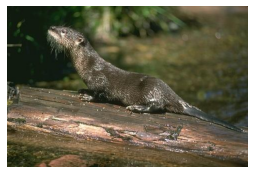

Mask image


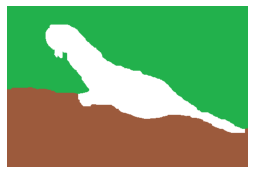

Ground-truth importance map


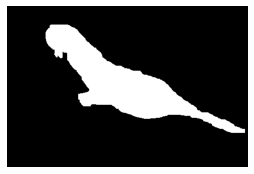

Predicted importance map


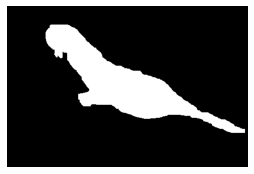

In [36]:
#show GT and prediction
img_name = 'img88'
idx = data_tst.index[data_tst["img_name"]==img_name][0] - 302

img_name = data_tst.iat[idx, 1]
print("Index: ", idx)
print("Image Name:", img_name)

src_img = cv.imread("database/imgs/" + img_name + ".bmp")
src_img = cv.cvtColor(src_img, cv.COLOR_BGR2RGB)
msk_img = cv.imread("database/imgs/msk/" + img_name + "_msk.bmp")
msk_img = cv.cvtColor(msk_img, cv.COLOR_BGR2RGB)    

print("Original image")
imshow(src_img, zoom=0.5)
print("Mask image")
imshow(msk_img, zoom=0.5)

num_rows = src_img.shape[0]
num_cols = src_img.shape[1]

imp_map = np.zeros((num_rows, num_cols))
imp_map_prd = np.zeros((num_rows, num_cols))

num_objs = int(data_tst.iat[idx, 0])
for obj_idx in range(num_objs):
  obj_name = data_tst.iat[idx+obj_idx, 2]
  obj_clr_r = data_tst.iat[idx+obj_idx, 3]
  obj_clr_g = data_tst.iat[idx+obj_idx, 4]
  obj_clr_b = data_tst.iat[idx+obj_idx, 5]

  # class_label = data_tst.iat[idx+obj_idx, 12]
  class_label = y_tst[idx+obj_idx]
  class_label_prd = model.predict((X_tst[idx+obj_idx],))
  imp_val = float(class_label) * 127.5
  imp_val_prd = float(class_label_prd) * 127.5

  for r in range(num_rows):
    for c in range(num_cols):
      if (msk_img[r, c, 0] == obj_clr_r) and \
        (msk_img[r, c, 1] == obj_clr_g) and \
        (msk_img[r, c, 2] == obj_clr_b):
        imp_map[r, c] = imp_val
        imp_map_prd[r, c] = imp_val_prd

print("Ground-truth importance map")
imshow(imp_map, cmap="gray", 
  vmin=0, vmax=255, zoom=0.5)

print("Predicted importance map")
imshow(imp_map_prd, cmap="gray", 
  vmin=0, vmax=255, zoom=0.5)